In [1]:
#module import 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 

In [2]:
def magnitude_to_components(vector_maginitude, angle):
    x_component = np.cos(angle)*vector_maginitude
    y_component = np.sin(angle)*vector_maginitude
    return x_component, y_component

def lift_coefficient():
    C_L = 1.0
    return C_L

def drag_coefficient():
    C_D = 0.3
    return C_D

def lift(C_L, rho, S, v_a, alpha):
    L = (C_L*rho*S*np.linalg.norm(v_a)**2)*np.sin(alpha)
    return L

def drag(C_D, rho, S, v_a, alpha):
    D = (C_D*rho*S*np.linalg.norm(v_a)**2)*np.cos(alpha)
    return D
    

def angle_of_atack(v_b, v_a):
    alpha = np.arccos(-(np.dot(v_a,v_b))/(np.linalg.norm(v_a)*np.linalg.norm(v_b)))
    return alpha 

def build_initial_conditions(initial_state, initial_mag_v_b, theta_b):
    x_0,y_0 = initial_state
    v_x_0, v_y_0 = magnitude_to_components(initial_mag_v_b, theta_b)

    return np.array([x_0, y_0, v_x_0, v_y_0])

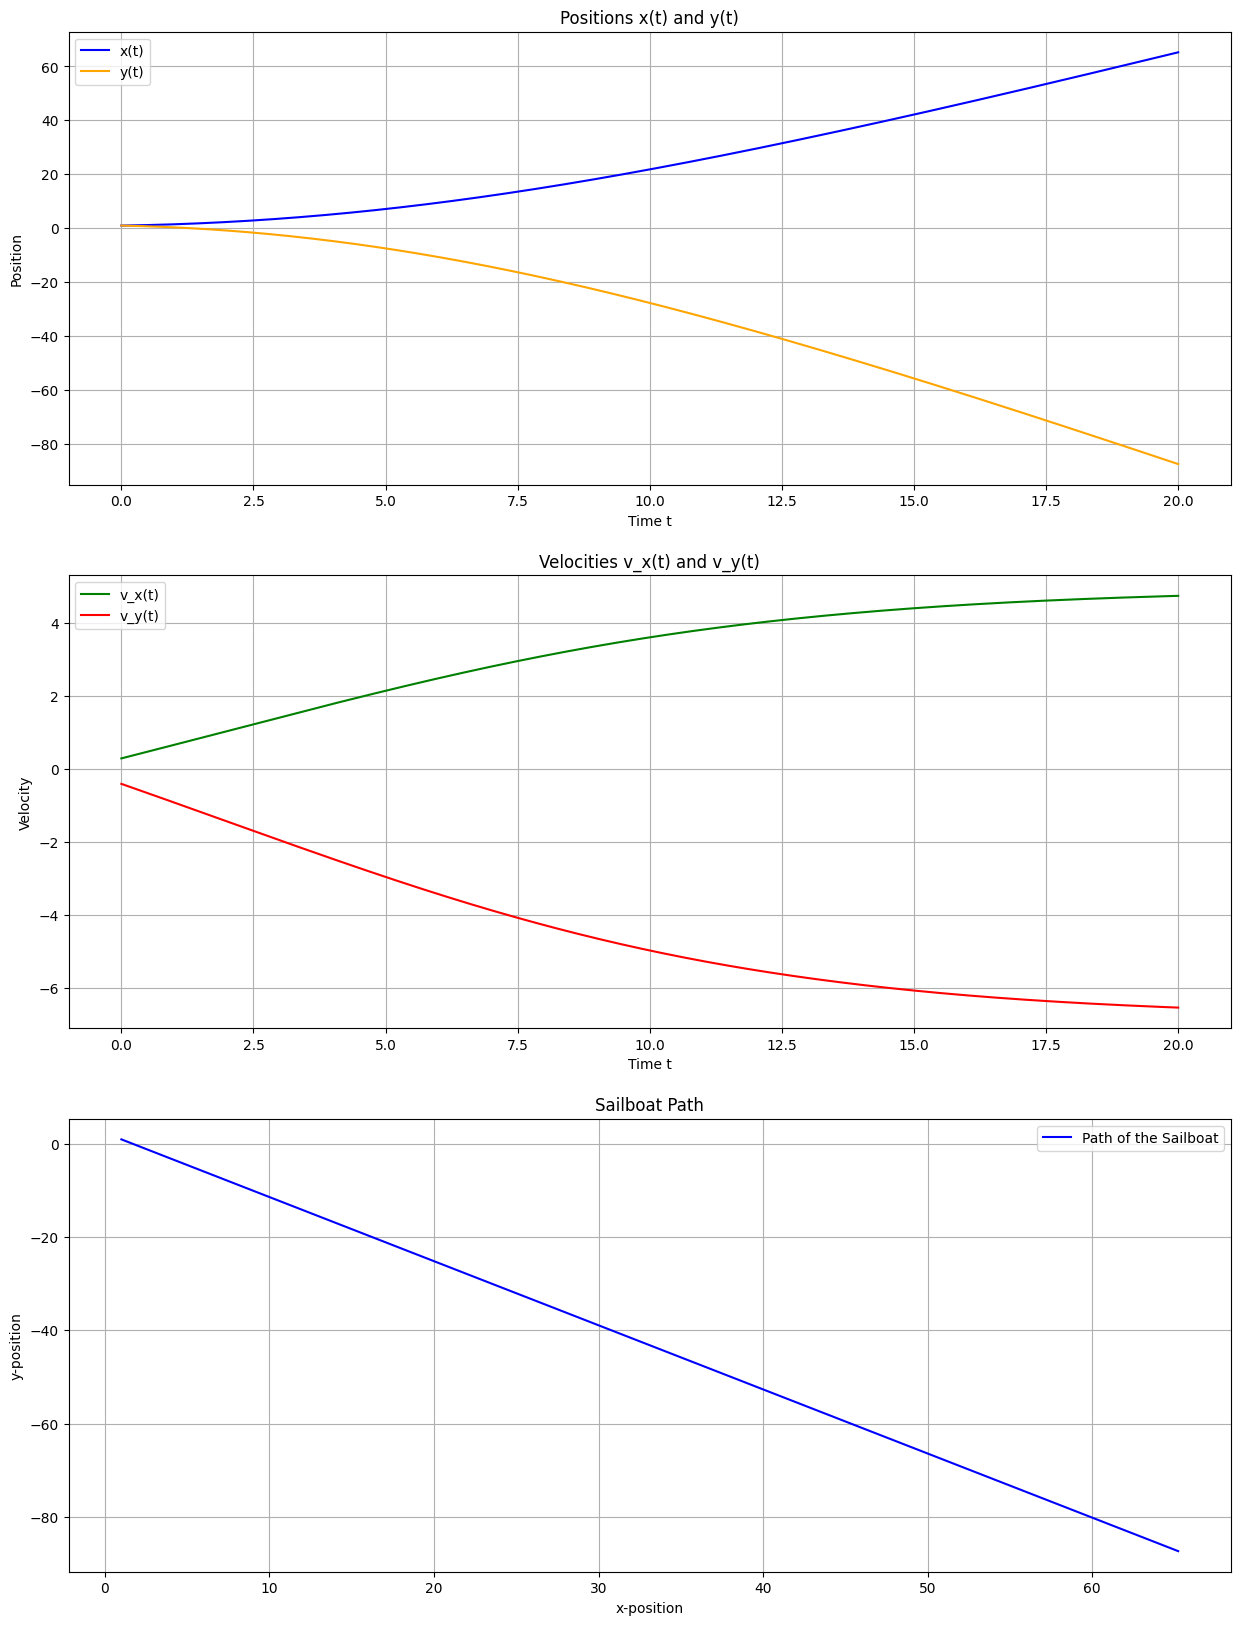

In [3]:
def system_ode(t, z, theta_b, theta_s, theta_w, mag_w_v_t, fixed_param):
    
    m_b, S, rho = fixed_param
    
    x, y, v_x, v_y = z

    v_t_x, v_t_y = magnitude_to_components(mag_w_v_t, theta_w)
    v_t = np.array([v_t_x, v_t_y])
    
    v_b = np.array([v_x, v_y])
    v_a = v_t - v_b
    
    alpha = angle_of_atack(v_b, v_a)
    
    C_L, C_D = lift_coefficient(), drag_coefficient()
    
    L = lift(C_L, rho, S, v_a, alpha)
    D = drag(C_D, rho, S, v_a, alpha)
    
    F = (L - D)/m_b
    
    F_x, F_y = magnitude_to_components(F, theta_b)      
    
    # Define the ODE system
    dx_dt = v_x
    dy_dt = v_y
    dv_x_dt = F_x
    dv_y_dt = F_y
    
    return np.array([dx_dt, dy_dt, dv_x_dt, dv_y_dt])



# Boat initial conditions/parameters 
intitial_state = np.array([1., 1.])
theta_b = 1.7*np.pi


#initial velo
initial_mag_v_b = 0.5
m_b = 100

#sail params
theta_s = 1
S = 5 #size of sail

#Wind parameters
mag_w_v_t = 4 
theta_w_t = np.pi 


#Enivorment parameters
rho_a = 1.225

#fixed parameters
fixed_param = np.array([m_b, S, rho_a])

#intial state vector 
z_0 = build_initial_conditions(intitial_state, initial_mag_v_b, theta_b)

# Time parameters 
t_span = (0, 20)  
t_eval = np.linspace(t_span[0], t_span[1], 500)  


# Solve the ODE
solution = solve_ivp(system_ode, t_span, z_0, t_eval=t_eval, method='RK45', args=(theta_b, theta_s, theta_w_t, mag_w_v_t, fixed_param))

# Extract the solution
t = solution.t
x, y, v_x, v_y = solution.y


# Plot the results
plt.figure(figsize=(15, 20))

# Plot x and y 
plt.subplot(3, 1, 1)
plt.plot(t, x, label='x(t)', color='blue')
plt.plot(t, y, label='y(t)', color='orange')
plt.title('Positions x(t) and y(t)')
plt.xlabel('Time t')
plt.ylabel('Position')
plt.legend()
plt.grid()

# Plot vx and vy 
plt.subplot(3, 1, 2)
plt.plot(t, v_x, label='v_x(t)', color='green')
plt.plot(t, v_y, label='v_y(t)', color='red')
plt.title('Velocities v_x(t) and v_y(t)')
plt.xlabel('Time t')
plt.ylabel('Velocity')
plt.legend()
plt.grid()

# Plot the path of the sailboat
plt.subplot(3, 1, 3)
plt.plot(x, y, label='Path of the Sailboat', color='blue')
plt.title('Sailboat Path')
plt.xlabel('x-position')
plt.ylabel('y-position')
plt.legend()
plt.grid()
plt.show()

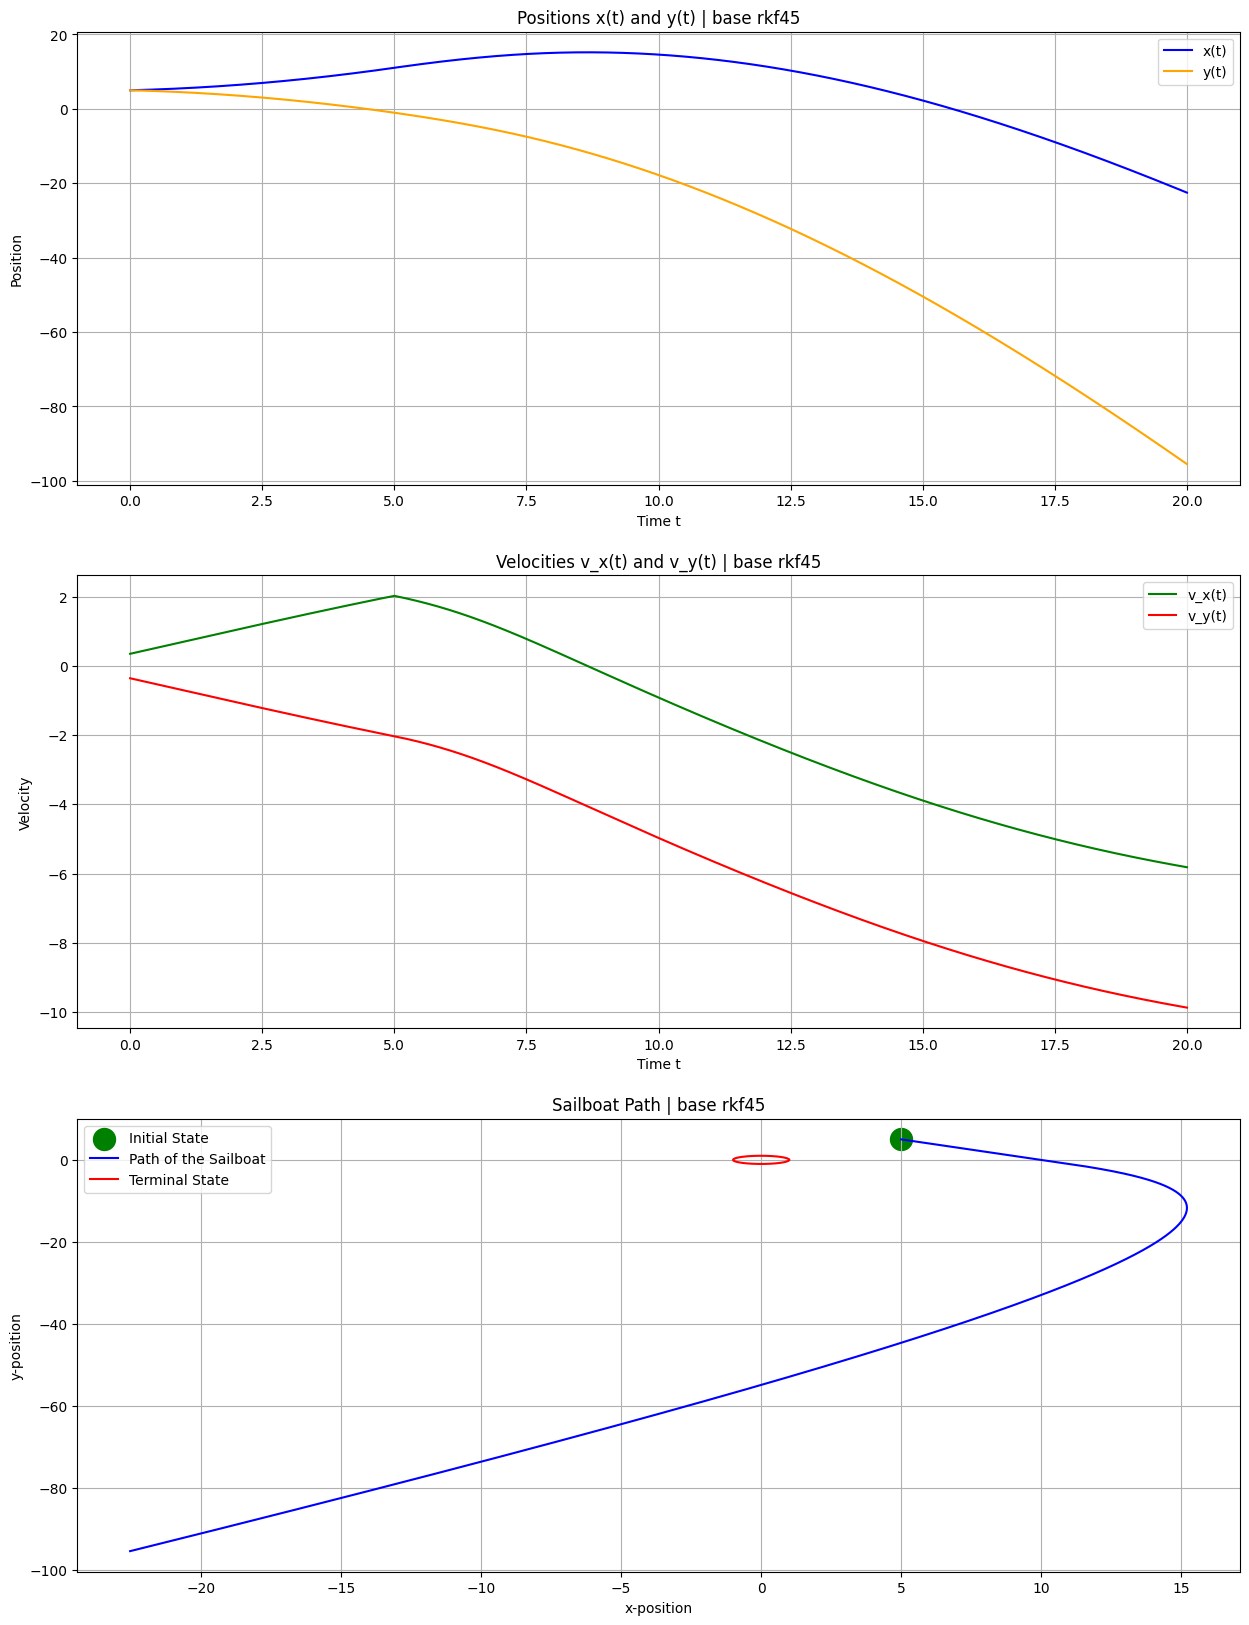

In [4]:
#manually coding the ode integrator, and then solver. Might come in handy later for the control part

def rkf45_step(f, t, z, h, args=()):


    k1 = h * f(t, z, *args)
    k2 = h * f(t + (1/4) * h, z + (1/4) * k1, *args)
    k3 = h * f(t + (3/8) * h, z + (3/32) * k1 + (9/32) * k2, *args)
    k4 = h * f(t + (12/13) * h, z + (1932/2197) * k1 - (7200/2197) * k2 + (7296/2197) * k3, *args)
    k5 = h * f(t + h, z + (439/216) * k1 - 8 * k2 + (3680/513) * k3 - (845/4104) * k4, *args)
    k6 = h * f(t + (1/2) * h, z - (8/27) * k1 + 2 * k2 - (3544/2565) * k3 + (1859/4104) * k4 - (11/40) * k5, *args)

    z_next = z + (16/135) * k1 + (6656/12825) * k3 + (28561/56430) * k4 - (9/50) * k5 + (2/55) * k6


    return z_next

def terminal_state_check(boat_pos, ternminal_state = (0,0), epislon = 1):
    x,y = boat_pos
    a,b = ternminal_state
    if (x-a)**2 + (y-b)**2 <= epislon**2:
        return True
    
    return False

def ivp_solver(ode_sys, z_0, t_eval, args=()):
    N = len(t_eval)
    D = len(z_0)
    
    z_sol = np.zeros((N, D))
    z_sol[0] = z_0 
    
        
    for i in range(1, N):
        
        if i == int(N/4):
            theta_b_updated = args[0] #- np.pi/2
            args = (theta_b_updated,) + args[1:]
            
        if terminal_state_check(z_sol[i-1][:2]): #if true then we have reached the terminal state
            
            return z_sol[:i,:], t_eval[:i]
        
        h = t_eval[i] - t_eval[i-1]
        z_sol[i] = rkf45_step(ode_sys, t_eval[i-1], z_sol[i-1], h, args)


    return z_sol, t_eval


# Boat initial conditions/parameters 
intitial_state = np.array([5., 5.])
theta_b = np.pi
initial_mag_v_b = 0.5
m_b = 100

#sail params
theta_s = np.pi
S = 5 #size of sail

#Wind parameters
mag_w_v_t = 4 
theta_w_t = np.pi 


#Enivorment parameters
rho_a = 1.225

#fixed parameters
fixed_param = np.array([m_b, S, rho_a])

#terminal state
coord_ts = (0,0)
epsilon = 1

#intial state vector 
z_0 = build_initial_conditions(intitial_state, initial_mag_v_b, theta_b)


# Time parameters 
t_span = (0, 20)  
t_eval = np.linspace(t_span[0], t_span[1], 5000)  

z_sol, t = ivp_solver(system_ode, z_0, t_eval, args=(theta_b, theta_s, theta_w_t, mag_w_v_t, fixed_param))

x,y,v_x,v_y = z_sol[:, 0], z_sol[:, 1], z_sol[:, 2], z_sol[:, 3]

# Plot the results
plt.figure(figsize=(15, 20))

plt.subplot(3, 1, 1)
plt.plot(t, x, label='x(t)', color='blue')
plt.plot(t, y, label='y(t)', color='orange')
plt.title('Positions x(t) and y(t) | base rkf45')
plt.xlabel('Time t')
plt.ylabel('Position')
plt.legend()
plt.grid()

# Plot vx and vy 
plt.subplot(3, 1, 2)
plt.plot(t, v_x, label='v_x(t)', color='green')
plt.plot(t, v_y, label='v_y(t)', color='red')
plt.title('Velocities v_x(t) and v_y(t) | base rkf45')
plt.xlabel('Time t')
plt.ylabel('Velocity')
plt.legend()
plt.grid()




# Create points on the circle
theta = np.linspace(0, 2 * np.pi, 200)  # 200 points evenly spaced around the circle
ts_x = coord_ts[0] + epsilon * np.cos(theta)
ts_y = coord_ts[1] + epsilon * np.sin(theta)

# Plot the path of the sailboat
plt.subplot(3, 1, 3)
plt.scatter(intitial_state[0], intitial_state[1], label = 'Initial State', color = 'green', s = 250)
plt.plot(x, y, label='Path of the Sailboat', color='blue')
plt.plot(ts_x, ts_y, label = 'Terminal State', color = 'red')
plt.title('Sailboat Path | base rkf45')
plt.xlabel('x-position')
plt.ylabel('y-position')
plt.legend()
plt.grid()
plt.show()
    

In [5]:
def terminal_state(coord=np.array([0,0]), epsilon = 0.5):
    pass


((np.pi/2)/4)*0.02

0.007853981633974483